In [11]:
import os
import json
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from plotly import graph_objs as go
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus

In [2]:
# load args
with open("../args.json", "r") as f:
    args = json.load(f)

In [43]:
# load similarity graph
path_graph = f'{args["results"]}graph/graph_{args["slice_type"]}.pkl'
with open(path_graph, "rb") as f:
    graph = pkl.load(f)

# Cumulative distribution

In [89]:
def cum_dist(serie):
    cum_dist = []
    cum = 0
    for elem in serie:
        cum+=elem
        cum_dist.append(cum)
    cum_dist = pd.Series([elem/cum_dist[-1] for elem in cum_dist])
    return cum_dist

In [91]:
similarities = pd.Series(np.concatenate([np.reshape(similarity_edge, -1) for similarity_edge in graph]))
similarities.sort_values(ascending=True, inplace=True)
cdf = cum_dist(similarities)

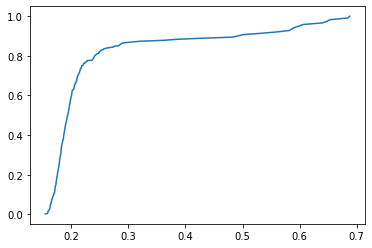

In [92]:
plt.plot(sorted_similarities, cdf)

In [93]:
similarities.describe()

count    378.000000
mean       0.209845
std        0.084292
min        0.154485
25%        0.175712
50%        0.187817
75%        0.205613
max        0.687474
dtype: float64

In [95]:
similarities.quantile(q=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.05    0.162822
0.10    0.166714
0.20    0.173425
0.30    0.178130
0.40    0.182310
0.50    0.187817
0.60    0.194219
0.70    0.200588
0.80    0.211549
0.90    0.243403
0.95    0.307471
0.99    0.641423
dtype: float64

# Load Model Output

In [202]:
path_corpus = f'{args["corpus"]}{args["slice_type"]}'
dict_files = sorted([file for file in os.listdir(path_corpus) if ".dict" in file])
path_models = f'{args["results"]}hdp/{args["slice_type"]}'
models_dir = sorted(os.listdir(path_models))

slices = range(1, len(models_dir)+1)
data = {}
for slice in slices:
    # load dictionary {word->id}
    path_dict = f'{path_corpus}/{dict_files[slice-1]}'
    token2id = Dictionary.load(path_dict).token2id

    # load topics distributions
    path_topics = f'{path_models}/{models_dir[slice-1]}/mode-topics.dat'
    with open(path_topics, "r") as f:
        topics = np.array([[int(word) for word in line.strip().split()] for line in f])
    topics_dists = (topics.T/topics.sum(axis=1)).T
    
    # load word assignments and get mixture weigths
    path_word_assignments = f"{path_models}/{models_dir[slice-1]}/mode-word-assignments.dat"
    word_assignments = []
    with open(path_word_assignments, "r") as f:
        lines = f.readlines()[1:]
        # (doc_id, word_id, topic_id, x)
        for line in lines:
            line = line.strip().split() 
            word_assignment = {"doc_id": int(line[0]) ,"word_id": int(line[1]), "topic_id": int(line[2])}
            word_assignments.append(word_assignment)
    
    # for each document get the number of words that each topic has
    word_assignments = pd.DataFrame(word_assignments, columns=["doc_id", "word_id", "topic_id"])
    word_assignments = word_assignments.pivot_table(index="doc_id", columns="topic_id", aggfunc="count")
    word_assignments.fillna(0, inplace=True)
    
    # for each document get the number of words
    doc_length = word_assignments.sum(axis=1) 
    
    # for each document get the topic proportions that draw the document (\pi_d)
    mixture_proportions = word_assignments.divide(doc_length, axis=0)
    
    # get the topic proportions in the corpus (\beta)
    mixture_weights = mixture_proportions.mean(axis=0).values
    
    #save data in a dict
    data[slice] = {"token2id": token2id, "topics_dists": topics_dists, "mixture_weights": mixture_weights}

# Graph

In [141]:
def get_topic_topn(data, topn):
    text_topn_words = []
    slices = list(data.keys())
    for slice in slices:
        token2id = data[slice]["token2id"]
        id2token = {v: k for k, v in token2id.items()}
        #for each (slice,i)
        for i, topic in enumerate(data[slice]["topics_dists"]):
            topn_ids = np.argsort(topic)[-topn:]
            topn_list = [id2token[id] for id in topn_ids]
            topn_str = "<br>".join(topn_list)
            text_topn_words.append(topn_str)
    return text_topn_words

In [221]:
def get_network_data(graph, topn=None):
    
    # nodes
    slices = range(1, len(graph)+1)
    nodes = np.array([[slice, i] for slice in slices for i in range(1, len(graph[slice-1])+1)])
    nodes = np.append(nodes, [[slices[-1]+1, i] for i in range(1, graph[slices[-1]-1].shape[1]+1)], axis=0)
    
    # edges
    edges = []
    for slice in slices:
        I = range(len(graph[slice-1]))
        for i in I:
            J = graph[slice-1][i].argsort()[::-1]
            # save larger edges
            if topn and topn<len(J):
                J = J[0:topn]
            for j in J:
                x  = [slice, slice+1]
                y  = [i+1, j+1]
                similarity = graph[slice-1][i,j]
                edges.append((x, y, similarity))         
      
    return nodes, edges  

In [244]:
def make_edge(x, y, text, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(width = width,
                                   color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       text      = text,
                       mode      = 'lines')
def plot_network(nodes, edges, text, color, threshold):
    # create node trace
    node_trace = go.Scatter(x = nodes[:,0], y = nodes[:,1], text = text,
                        mode = 'markers',
                        hoverinfo = 'text',
                        marker = dict(
                            showscale = True,
                            colorscale = 'YlGnBu',
                            reversescale = True,
                            color = color,
                            size = 20,
                            colorbar = dict(
                                thickness = 30,
                                title = 'Topic size',
                                xanchor = 'left',
                                titleside = 'right',
                            ),
                        line_width = 2,
                        cmin=0.0
                        ),
                        customdata=100*color,
                        hovertemplate='%{text}<br></b><br></b>topic_size[%]: %{customdata:.2f}'
                        )
    # create edge traces
    edge_trace = []
    for edge in edges:
        x = edge[0]
        y = edge[1]
        x = np.linspace(x[0], x[1], 50)
        y = np.linspace(y[0], y[1], 50)
        similarity = edge[2]
        if similarity >= threshold:
            trace = make_edge(x, y, f"{round(similarity,3)}", width = 4*similarity) 
            edge_trace.append(trace)
        
    # layout
    layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)', 
    xaxis =  {'showgrid': False, 'zeroline': False}, 
    yaxis = {'showgrid': False, 'zeroline': False},
    )
    # create figure
    fig = go.Figure(layout = layout)
    # add all edge traces
    for trace in edge_trace:
        fig.add_trace(trace)
    # add node trace
    fig.add_trace(node_trace)
    # remove legend
    fig.update_layout(showlegend = False)
    # tick labels
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=True, tickvals=list(range(1,nodes.max()+1,1)))
    fig.update_yaxes(showticklabels = False)
    # show figure
    fig.show()
    return fig

In [249]:
# network data
nodes, edges = get_network_data(graph, None)
text = get_topic_topn(data, 20)
color = np.array([weight for slice in slices for weight in data[slice]["mixture_weights"]])

In [250]:
fig = plot_network(nodes, edges, text, color, distances.quantile(0.00))
fig.write_html("graph_max_one_edge.html")

# Search word in corpus

In [241]:
df = pd.read_pickle("../data/robos_prose.pkl")
df["year"] = df.apply(lambda x: x["sin_fecha_siniestro"].year, axis=1)

In [242]:
find = [i for i, doc in enumerate(df["sin_relato"]) for word in doc.split() if "apropiacion"== word.lower()]
df.iloc[find].groupby("year").count()

,sin_fecha_siniestro,sin_relato
year,,
2011,10,10
2012,23,23
2013,18,18
2014,25,25
2015,22,22
2016,37,37
